# MULTIVARIATE ANALYSIS AND STATISTICAL LEARNING
## Applying Hierarchical Clustering to Radiomics dataset

- Lorenzo Pratesi Mariti - lorenzo.pratesi@stud.unifi.it

This dataset collects features on images of prostate cancer. Clustering is meant to check if these features are able to predict a Gravity Score (5 levels).

In [584]:
# Import some libraries
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import cut_tree
from scipy.cluster.hierarchy import dendrogram, linkage

### Preprocessing functions
Before start to analyze the dataset we have to make it clean, for this purpose, we define two functions that check if there are some troubles with the dataset. The first function drops the rows that have all value set to null or zero, the second functions normalize the entire dataset, the idea behind normalization is that it will transform the data such that the distribution will have a mean value 0 and standard deviation of 1.

In [585]:
def discard_error_features(radiomics_df):
    radiomics_clean = radiomics_df
    # now let´s discard patients whose features are all zeros
    end_ind = radiomics_clean.shape[1]
    cut_mat = radiomics_clean.iloc[:, 3:end_ind]  # matrix without patient ID
    check = cut_mat.isnull().sum(axis=1).to_numpy().nonzero()  # inex of zero rows
    radiomics_clean = radiomics_clean.drop(radiomics_clean.index[check])  # updated matrix
    return radiomics_clean

def normalize_values(radiomics_df):
    df = radiomics_df.copy()
    cols = df.columns.tolist()  # name of all the columns
    val = df.values[:, 2:df.shape[1]]
    first2 = df.values[:, 0:2]
    # now need to scale just starting from column 2
    scaled_features = preprocessing.StandardScaler().fit_transform(val)
    conc = np.concatenate((first2, scaled_features), axis=1)
    output_normalized = pd.DataFrame(data=conc,  # values
                                     index=df.index,  # 1st column as index
                                     columns=cols)  # 1st row as the column names
    return output_normalized

### Read the data
Let's begin! We read the data about Radiomics of prostate cancer and we apply the two functions described before for cleaning and normalizing the dataset.

In [617]:
radiomics_df = pd.read_csv("Radiomics.csv")

radiomics_clean = discard_error_features(radiomics_df).reset_index(drop=True)
radiomics_norm = normalize_values(radiomics_clean)

# Fix the patient id with a robust identifier
paz_list = ['P' + str(i) for i in range(0, radiomics_df.shape[0] + 1)]
radiomics_norm['PAZ'] = pd.Series(paz_list)
radiomics_norm

,PAZ,diagnostics_Image-original_Mean,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-corrected_VoxelNum,diagnostics_Mask-corrected_Mean,diagnostics_Mask-corrected_Minimum,diagnostics_Mask-corrected_Maximum,original_shape_Elongation,original_shape_Flatness,...,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,P0,174.617,0.627698,2.58235,2.5823,-0.414947,-1.08079,0.0281333,-0.0428632,0.38842,...,-0.153486,-0.944304,-1.16774,-0.538519,-1.11821,1.78477,-1.22004,0.243095,-1.06359,-1.23274
1,P1,217.169,3.63219,0.600832,0.599939,0.292278,-1.08079,2.64928,0.580377,0.126103,...,-0.688029,-1.00025,0.325178,1.9883,-0.697297,-0.166624,-1.06725,4.95813,-0.284873,0.350676
2,P2,128.654,-1.86069,0.069545,0.0684257,-1.26276,-0.368246,-1.41288,0.0834828,0.589572,...,4.70272,2.1492,-1.49153,-1.10229,0.246772,1.94406,-0.923828,-0.929341,-0.75525,-1.24423
3,P3,186.965,1.33735,-0.332058,-0.333348,-0.451394,-0.139215,-0.419076,-0.554658,0.20496,...,-0.48124,0.0138866,0.79843,-0.0931938,0.133931,-0.273129,0.229117,-0.495261,-0.0703352,-0.176421
4,P4,175.656,0.590833,-0.286041,-0.287311,1.15036,0.802358,0.848018,-0.480932,-1.706,...,-0.872327,-0.973763,1.40823,1.53951,-0.32524,-0.401489,-0.0467369,0.603401,-0.113042,1.09961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,P97,152.697,-0.810035,-0.359947,-0.361249,-0.0451858,-0.241007,-0.294851,0.290099,0.963946,...,-0.362976,-0.385252,0.447893,-0.0957696,1.00027,-0.39589,0.658276,-0.21438,0.198467,0.295154
98,P98,137.102,1.58619,-0.216318,-0.217559,-0.178828,-0.928101,1.00951,-0.191431,0.0195582,...,-0.40938,-1.03479,-1.08591,-0.221874,-1.05578,-0.349304,-0.424696,0.17579,-0.855707,0.792455
99,P99,163.139,-0.238628,0.450231,0.449274,-1.05697,-0.953549,0.0157108,0.148889,1.08635,...,0.608998,0.23444,-0.964246,-0.587701,-0.317813,0.397002,-1.05427,0.324469,-0.83436,-0.824015
100,P100,104.912,-1.95285,-0.358552,-0.359854,-1.26198,-0.495486,-1.17685,-0.224537,0.766948,...,0.0264693,0.230646,-0.614343,-0.744644,0.0592278,-0.252931,0.641805,-0.686443,-0.188412,-0.214234


### Extract features

In [587]:
# A list of the valid features, sorted
feature_names = list(filter(lambda feature: feature.startswith("original_"), radiomics_norm))
samples = radiomics_norm[feature_names].to_numpy()

### Multidimensional scaling with PCA
Multidimensional scaling is a way to visualize very high dimensional data in a lower-dimensional space. In our case, the feature space is 107-dimensional space. Let's pass 0.9 as a parameter to the PCA model, which means that PCA will hold 90% of the variance and the number of components required to capture 90% variance will be used.

In [588]:
scaler = preprocessing.StandardScaler().fit(samples)
rad4PCA = scaler.transform(samples)
# Make an instance of the Model
pca = PCA(0.9).fit(rad4PCA)

let's find out how many components PCA used to capture 0.9 variance.

In [618]:
numb_of_left_feat = pca.n_components_
new_feat = pca.transform(rad4PCA)
pca_df = pd.DataFrame(pca.components_, columns=feature_names, 
                      index=["PC" + str(i) for i in range(numb_of_left_feat)])
pca_df.T

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
original_shape_Elongation,-0.008735,-0.018955,-0.050460,-0.016429,0.033242,0.045200,-0.390594,0.207055,0.019477,-0.051859
original_shape_Flatness,0.021734,0.049064,-0.110671,0.257979,0.056338,0.136616,-0.173389,0.175197,0.007771,0.043442
original_shape_LeastAxisLength,0.026653,0.162532,-0.011241,0.154553,0.018544,0.051701,0.024555,0.014961,-0.033225,0.037209
original_shape_MajorAxisLength,0.003499,0.105147,-0.005287,0.025617,-0.001295,-0.087879,0.346911,-0.218110,-0.092207,0.187559
original_shape_Maximum2DDiameterColumn,0.035234,0.178033,0.046159,0.041106,-0.004692,0.018639,0.015780,-0.037219,-0.001412,-0.020056
...,...,...,...,...,...,...,...,...,...,...
original_ngtdm_Busyness,-0.020965,0.143070,0.174821,0.022835,0.025138,-0.017972,-0.047658,0.021601,-0.039532,0.057972
original_ngtdm_Coarseness,-0.039928,-0.126686,0.117386,-0.127098,-0.029788,-0.154530,0.040469,0.099083,0.086314,-0.038567
original_ngtdm_Complexity,0.134021,0.042416,-0.017714,-0.041414,0.145818,0.046714,0.013392,-0.022603,0.100967,-0.017684
original_ngtdm_Contrast,0.066524,-0.119604,0.177524,0.024652,0.039874,-0.043620,-0.048573,-0.032026,-0.073731,0.133419


From the above output, you can observe that to achieve 90% variance, the dimension was reduced to 10 principal components from the actual 107 dimensions.

### Plot features as a heatmap
A heat map gives the correlation of features to each other, red indicating positive correlation, and blue negative. A heatmap may be clustered to show groupings of features that are similar.

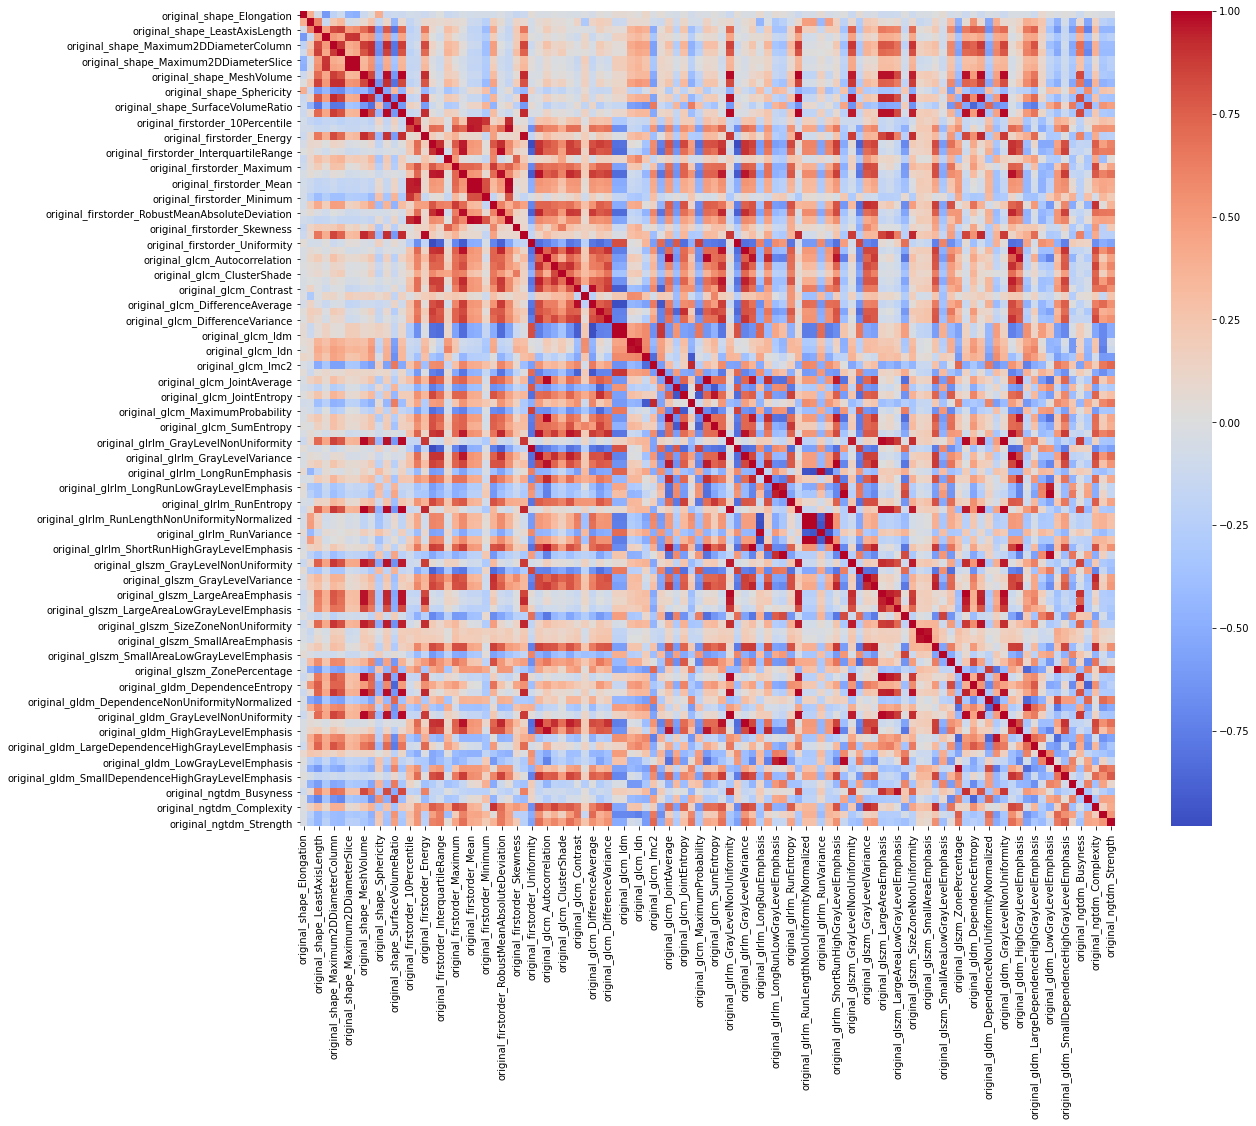

In [590]:
# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names)

corr = d.astype('float64').corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Draw the heatmap using seaborn
sns.heatmap(corr, cmap='coolwarm', square=True)
plt.show()

### Cluster the heatmap, using hierarchical clustering on data processed with PCA
Here we take the features set and cluster obtained from PCA and we construct the dendrogram. In the dendrogram, there are 3 major groups, and many smaller groupings based on features. We use Ward's method as the linkage criteria, that minimizes the sum of squared differences within all clusters.

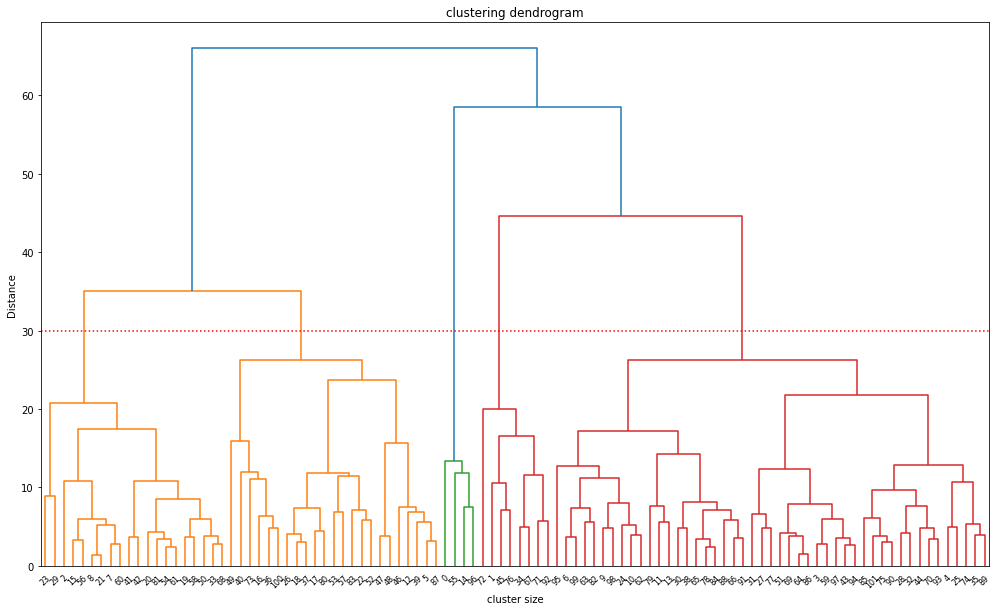

In [591]:
z = linkage(new_feat, 'ward')

fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(1, 1, 1)

# Threshold for division into clusters
ax.axhline(y=30, xmin=0, xmax=1, color='red', linestyle='dotted')

dendrogram(z, ax=ax, p=10, leaf_rotation=45, leaf_font_size=8, show_leaf_counts=True,
           show_contracted=True)

plt.title('clustering dendrogram')
plt.xlabel('cluster size')
plt.ylabel('Distance')
plt.show()

Now we can cut the tree to obtain the 5 clusters that we need. Before retrieving the clusters let's truncate the dendrogram to condense the tree for better visualization.

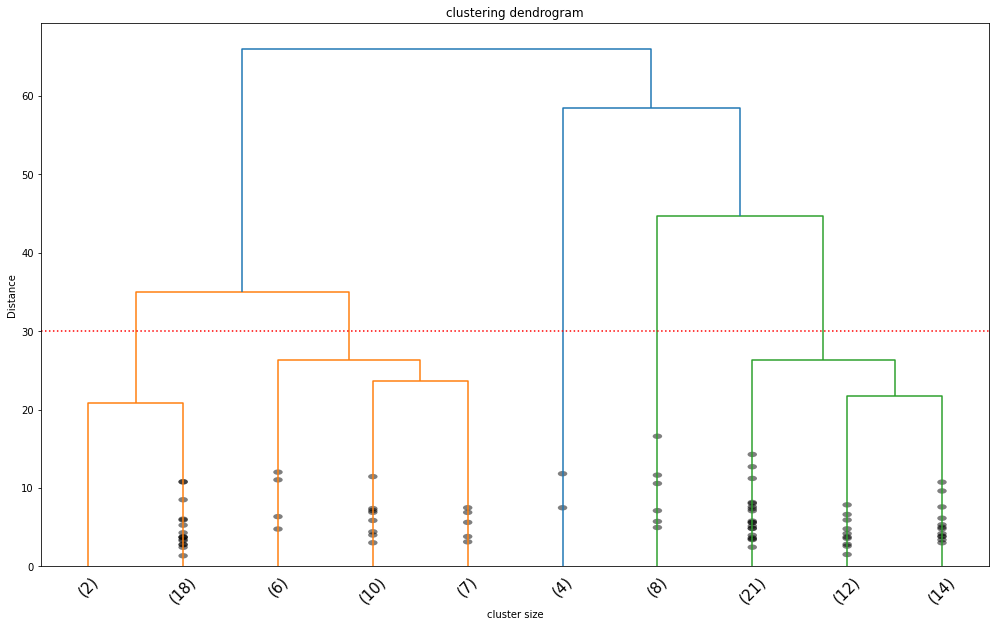

In [597]:
fig = plt.figure(figsize=(17,10))
ax = fig.add_subplot(1, 1, 1)

# Threshold for division into clusters
ax.axhline(y=30, xmin=0, xmax=1, color='red', linestyle='dotted')

dendrogram(z, truncate_mode='lastp', p=10, leaf_rotation=45, leaf_font_size=15, show_leaf_counts=True,
           show_contracted=True)
plt.title('clustering dendrogram')
plt.xlabel('cluster size')
plt.ylabel('Distance')
plt.show()

In [609]:
max_d = 5
cluster_cut = pd.DataFrame(pd.Series(cut_tree(z, n_clusters=max_d).reshape(-1, )), columns=['ClusterID'])
cdf = pd.concat([radiomics_norm['PAZ'], cluster_cut + 1], axis=1)
cdf

,PAZ,ClusterID
0,P0,1
1,P1,2
2,P2,3
3,P3,4
4,P4,4
...,...,...
97,P97,4
98,P98,4
99,P99,4
100,P100,5


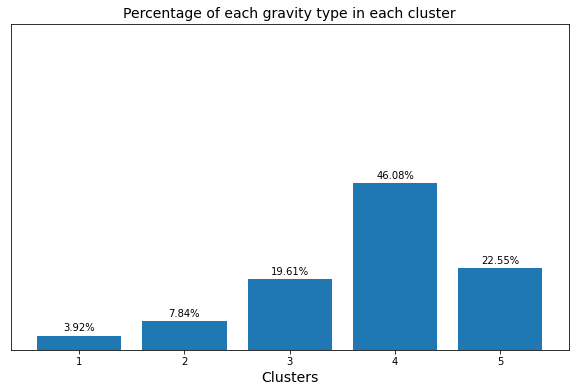

In [599]:
grouped_df = cdf.groupby(['ClusterID', cdf.index]).agg({'PAZ': 'sum'})
percents_df = grouped_df.groupby(level=0).apply(lambda x: 100 * len(x) / len(grouped_df))

ax = percents_df.plot(kind='bar', figsize=(10, 6), width=0.8, rot=0)
ax.axes.yaxis.set_visible(False)
ax.set_yticks(range(0, 100, 10))
plt.title("Percentage of each gravity type in each cluster", fontsize=14)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.xlabel('Clusters', fontsize=14)
    ax.annotate("{:.2%}".format(height / 100), (x + width / 2, y + height + 1.3), ha='center')

plt.show()

### Report the clustering results to CSV file
Finally, we concatenate the clustered groups to the original dataset and save it in a CSV format

result_df = pd.concat([radiomics_clean, cdf['ClusterID']], axis=1)

result_df['PAZ'] = radiomics_clean['PAZ']
result_df.to_csv('RadiomicsClusters.csv', index=False)

In [616]:
result_df = pd.concat([radiomics_clean, cdf['ClusterID']], axis=1)

result_df['PAZ'] = radiomics_clean['PAZ']
result_df.to_csv('RadiomicsClusters.csv', index=False)